In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import warnings
import json
import time
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

warnings.filterwarnings("ignore")

#### ===========================
#### DEVICE SETUP
#### ===========================

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


#### ===========================
#### DATASET SETUP
#### ===========================

In [4]:
print("Loading Brain Tumor MRI dataset...")

# Enhanced augmentation for MRI scans
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((240, 240)),
        transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

train_path = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_path = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# Load and split dataset (85% train / 15% val)
full_train_dataset = datasets.ImageFolder(root=train_path,
                                        transform=data_transforms['val'])
train_size = int(0.85 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
indices = list(range(len(full_train_dataset)))
np.random.seed(42)
np.random.shuffle(indices)
train_indices, val_indices = indices[:train_size], indices[train_size:]

train_dataset_aug = datasets.ImageFolder(root=train_path,
                                       transform=data_transforms['train'])
train_dataset = Subset(train_dataset_aug, train_indices)
val_dataset = Subset(full_train_dataset, val_indices)
test_dataset = datasets.ImageFolder(root=test_path,
                                  transform=data_transforms['val'])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                      shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                       shuffle=False, num_workers=2, pin_memory=True)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

Loading Brain Tumor MRI dataset...
Training samples: 4855
Validation samples: 857
Testing samples: 1311


#### ===========================
#### MODEL SETUP (ResNet50)
#### ===========================

In [5]:
print("\nLoading pre-trained ResNet50 (ImageNet weights)...")

# 1. Initialize the model architecture WITHOUT weights first
model = models.resnet50(weights=None)

# 2. IMPORTANT: Update this path to your local weights file
WEIGHTS_FILE = '/kaggle/input/resnet50-weights/pytorch/default/1/resnet50-0676ba61.pth'

# 3. Load the state dictionary
try:
    checkpoint = torch.load(WEIGHTS_FILE, map_location=device)
    
    if isinstance(checkpoint, dict):
        if 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        elif 'model' in checkpoint:
            state_dict = checkpoint['model']
        elif 'model_state_dict' in checkpoint:
            state_dict = checkpoint['model_state_dict']
        else:
            state_dict = checkpoint
    else:
        state_dict = checkpoint

    if any(k.startswith('module.') for k in state_dict.keys()):
        state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}

    missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=False)

    print("✓ ResNet-50 weights loaded successfully from local file.")
    if missing_keys:
        print(f"  Missing keys (expected for fc layer): {missing_keys}")
    if unexpected_keys:
        print(f"  Unexpected keys: {unexpected_keys}")

except Exception as e:
    print(f"ERROR loading weights: {e}")
    try:
        state_dict = torch.load(WEIGHTS_FILE, map_location=device, weights_only=True)
        model.load_state_dict(state_dict, strict=False)
        print("✓ Weights loaded successfully with weights_only=True")
    except Exception as e2:
        print(f"FATAL ERROR: Could not load weights - {e2}")
        raise


Loading pre-trained ResNet50 (ImageNet weights)...
✓ ResNet-50 weights loaded successfully from local file.


In [ ]:
# Freeze all parameters initially
for param in model.parameters():
    param.requires_grad = False

# Replace classifier (fc layer)
num_ftrs = model.fc.in_features # resnet50: 2048 features

model.fc = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(p=0.4),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(p=0.3),
    nn.Linear(256, 4)
)

model = model.to(device)
print(f"\nModel: resnet50 with Custom Classifier")
print(f"Initial trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Model: resnet50 with Custom Classifier
Initial trainable parameters: 1,182,980


#### ===========================
#### PROGRESSIVE UNFREEZING HELPER
#### ===========================

In [7]:
def unfreeze_resnet_layers(model, phase):
    """
    Progressively unfreeze ResNet layers
    ResNet50 structure: conv1, bn1, relu, maxpool, layer1, layer2, layer3, layer4, fc
    """
    for name, param in model.named_parameters():
        if 'fc' not in name:
            param.requires_grad = False

    if phase == 2:
        for param in model.layer4.parameters():
            param.requires_grad = True
    elif phase == 3:
        for param in model.layer3.parameters():
            param.requires_grad = True
        for param in model.layer4.parameters():
            param.requires_grad = True
    elif phase == 4:
        for param in model.parameters():
            param.requires_grad = True

    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#### ===========================
#### TRAINING CONFIGURATION
#### ===========================

In [8]:
criterion = nn.CrossEntropyLoss()

training_phases = [
    {'name': 'Phase 1: Train FC Only', 'phase': 1, 'epochs': 5, 'lr_backbone': 0, 'lr_fc': 1e-3},
    {'name': 'Phase 2: Unfreeze Layer4', 'phase': 2, 'epochs': 5, 'lr_backbone': 5e-5, 'lr_fc': 5e-4},
    {'name': 'Phase 3: Unfreeze Layer3-4', 'phase': 3, 'epochs': 5, 'lr_backbone': 3e-5, 'lr_fc': 3e-4},
    {'name': 'Phase 4: Full Fine-tuning', 'phase': 4, 'epochs': 15, 'lr_backbone': 1e-5, 'lr_fc': 1e-4},
]

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = 0
best_model_state = None

#### ===========================
#### TRAINING LOOP
#### ===========================

In [9]:
print("\n" + "="*70)
print("STARTING PROGRESSIVE TRAINING (ResNet50)")
print("="*70)

start_time = time.time()
total_epochs = sum(p['epochs'] for p in training_phases)
epoch_counter = 0

for phase_cfg in training_phases:
    print(f"\n{'='*70}\n{phase_cfg['name']}\n{'='*70}")
    trainable_params = unfreeze_resnet_layers(model, phase_cfg['phase'])
    print(f"Trainable parameters: {trainable_params:,}")

    if phase_cfg['phase'] == 1:
        optimizer = optim.Adam(model.fc.parameters(), lr=phase_cfg['lr_fc'])
    else:
        optimizer = optim.Adam([
            {'params': [p for n, p in model.named_parameters() if 'fc' not in n and p.requires_grad],
             'lr': phase_cfg['lr_backbone']},
            {'params': model.fc.parameters(), 'lr': phase_cfg['lr_fc']}
        ])
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=phase_cfg['epochs'], eta_min=1e-6)

    for epoch in range(phase_cfg['epochs']):
        epoch_counter += 1

        # ---- TRAINING ----
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch_counter}/{total_epochs} [Train]")
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        train_loss = running_loss / total
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # ---- VALIDATION ----
        model.eval()
        val_loss_total, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss_total += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_loss_total / val_total
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch_counter}/{total_epochs} -> Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            print(f"✓ New best validation accuracy: {best_val_acc:.2f}%")

        scheduler.step()

# Load best model
model.load_state_dict(best_model_state)


STARTING PROGRESSIVE TRAINING (ResNet50)

Phase 1: Train FC Only
Trainable parameters: 1,182,980


Epoch 1/30 [Train]: 100%|██████████| 76/76 [00:31<00:00,  2.45it/s, loss=0.4746]


Epoch 1/30 -> Train Acc: 77.59% | Val Acc: 86.93%
✓ New best validation accuracy: 86.93%


Epoch 2/30 [Train]: 100%|██████████| 76/76 [00:24<00:00,  3.07it/s, loss=0.4440]


Epoch 2/30 -> Train Acc: 81.69% | Val Acc: 85.30%


Epoch 3/30 [Train]: 100%|██████████| 76/76 [00:24<00:00,  3.08it/s, loss=0.4392]


Epoch 3/30 -> Train Acc: 83.95% | Val Acc: 88.10%
✓ New best validation accuracy: 88.10%


Epoch 4/30 [Train]: 100%|██████████| 76/76 [00:24<00:00,  3.07it/s, loss=0.3140]


Epoch 4/30 -> Train Acc: 84.63% | Val Acc: 88.21%
✓ New best validation accuracy: 88.21%


Epoch 5/30 [Train]: 100%|██████████| 76/76 [00:24<00:00,  3.11it/s, loss=0.4830]


Epoch 5/30 -> Train Acc: 85.44% | Val Acc: 88.68%
✓ New best validation accuracy: 88.68%

Phase 2: Unfreeze Layer4
Trainable parameters: 16,147,716


Epoch 6/30 [Train]: 100%|██████████| 76/76 [00:26<00:00,  2.91it/s, loss=0.2546]


Epoch 6/30 -> Train Acc: 89.02% | Val Acc: 92.42%
✓ New best validation accuracy: 92.42%


Epoch 7/30 [Train]: 100%|██████████| 76/76 [00:25<00:00,  2.93it/s, loss=0.1891]


Epoch 7/30 -> Train Acc: 92.17% | Val Acc: 94.05%
✓ New best validation accuracy: 94.05%


Epoch 8/30 [Train]: 100%|██████████| 76/76 [00:25<00:00,  2.96it/s, loss=0.0560]


Epoch 8/30 -> Train Acc: 94.29% | Val Acc: 94.40%
✓ New best validation accuracy: 94.40%


Epoch 9/30 [Train]: 100%|██████████| 76/76 [00:24<00:00,  3.04it/s, loss=0.1646]


Epoch 9/30 -> Train Acc: 95.30% | Val Acc: 96.03%
✓ New best validation accuracy: 96.03%


Epoch 10/30 [Train]: 100%|██████████| 76/76 [00:25<00:00,  2.97it/s, loss=0.1106]


Epoch 10/30 -> Train Acc: 95.76% | Val Acc: 96.03%

Phase 3: Unfreeze Layer3-4
Trainable parameters: 23,246,084


Epoch 11/30 [Train]: 100%|██████████| 76/76 [00:30<00:00,  2.46it/s, loss=0.1283]


Epoch 11/30 -> Train Acc: 95.28% | Val Acc: 95.80%


Epoch 12/30 [Train]: 100%|██████████| 76/76 [00:30<00:00,  2.47it/s, loss=0.0789]


Epoch 12/30 -> Train Acc: 96.68% | Val Acc: 95.80%


Epoch 13/30 [Train]: 100%|██████████| 76/76 [00:30<00:00,  2.47it/s, loss=0.1231]


Epoch 13/30 -> Train Acc: 97.16% | Val Acc: 96.85%
✓ New best validation accuracy: 96.85%


Epoch 14/30 [Train]: 100%|██████████| 76/76 [00:30<00:00,  2.46it/s, loss=0.0384]


Epoch 14/30 -> Train Acc: 98.02% | Val Acc: 97.43%
✓ New best validation accuracy: 97.43%


Epoch 15/30 [Train]: 100%|██████████| 76/76 [00:30<00:00,  2.47it/s, loss=0.0182]


Epoch 15/30 -> Train Acc: 97.98% | Val Acc: 97.08%

Phase 4: Full Fine-tuning
Trainable parameters: 24,691,012


Epoch 16/30 [Train]: 100%|██████████| 76/76 [00:48<00:00,  1.57it/s, loss=0.0172]


Epoch 16/30 -> Train Acc: 98.08% | Val Acc: 97.55%
✓ New best validation accuracy: 97.55%


Epoch 17/30 [Train]: 100%|██████████| 76/76 [00:48<00:00,  1.57it/s, loss=0.0502]


Epoch 17/30 -> Train Acc: 98.25% | Val Acc: 97.55%


Epoch 18/30 [Train]: 100%|██████████| 76/76 [00:48<00:00,  1.57it/s, loss=0.0071]


Epoch 18/30 -> Train Acc: 98.52% | Val Acc: 97.67%
✓ New best validation accuracy: 97.67%


Epoch 19/30 [Train]: 100%|██████████| 76/76 [00:48<00:00,  1.57it/s, loss=0.0640]


Epoch 19/30 -> Train Acc: 98.35% | Val Acc: 97.55%


Epoch 20/30 [Train]: 100%|██████████| 76/76 [00:48<00:00,  1.57it/s, loss=0.0742]


Epoch 20/30 -> Train Acc: 98.78% | Val Acc: 97.55%


Epoch 21/30 [Train]: 100%|██████████| 76/76 [00:48<00:00,  1.57it/s, loss=0.0111]


Epoch 21/30 -> Train Acc: 98.74% | Val Acc: 97.78%
✓ New best validation accuracy: 97.78%


Epoch 22/30 [Train]: 100%|██████████| 76/76 [00:48<00:00,  1.57it/s, loss=0.0452]


Epoch 22/30 -> Train Acc: 98.97% | Val Acc: 98.02%
✓ New best validation accuracy: 98.02%


Epoch 23/30 [Train]: 100%|██████████| 76/76 [00:48<00:00,  1.57it/s, loss=0.0211]


Epoch 23/30 -> Train Acc: 99.13% | Val Acc: 97.90%


Epoch 24/30 [Train]: 100%|██████████| 76/76 [00:48<00:00,  1.57it/s, loss=0.0373]


Epoch 24/30 -> Train Acc: 99.07% | Val Acc: 97.78%


Epoch 25/30 [Train]: 100%|██████████| 76/76 [00:48<00:00,  1.57it/s, loss=0.0032]


Epoch 25/30 -> Train Acc: 99.34% | Val Acc: 98.25%
✓ New best validation accuracy: 98.25%


Epoch 26/30 [Train]: 100%|██████████| 76/76 [00:48<00:00,  1.58it/s, loss=0.0505]


Epoch 26/30 -> Train Acc: 99.34% | Val Acc: 98.02%


Epoch 27/30 [Train]: 100%|██████████| 76/76 [00:48<00:00,  1.57it/s, loss=0.0109]


Epoch 27/30 -> Train Acc: 99.05% | Val Acc: 98.13%


Epoch 28/30 [Train]: 100%|██████████| 76/76 [00:48<00:00,  1.57it/s, loss=0.0242]


Epoch 28/30 -> Train Acc: 99.30% | Val Acc: 97.90%


Epoch 29/30 [Train]: 100%|██████████| 76/76 [00:48<00:00,  1.57it/s, loss=0.0103]


Epoch 29/30 -> Train Acc: 99.46% | Val Acc: 98.13%


Epoch 30/30 [Train]: 100%|██████████| 76/76 [00:48<00:00,  1.57it/s, loss=0.0504]


Epoch 30/30 -> Train Acc: 99.28% | Val Acc: 98.25%


<All keys matched successfully>

#### ===========================
#### FINAL TEST EVALUATION
#### ===========================

In [10]:
print("\n" + "="*70)
print("FINAL TEST EVALUATION (ResNet50)")
print("="*70)

model.eval()
test_correct, test_total = 0, 0
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (preds == labels).sum().item()

test_acc = 100 * test_correct / test_total


FINAL TEST EVALUATION (ResNet50)


Testing: 100%|██████████| 21/21 [00:06<00:00,  3.23it/s]


#### ===========================
#### RESULTS & VISUALIZATION
#### ===========================


Best Validation Accuracy: 98.25%
Final Test Accuracy: 98.47%
Total Training Time: 22.64 minutes

✓ SUCCESS! resnet50 matches or surpasses your baseline!


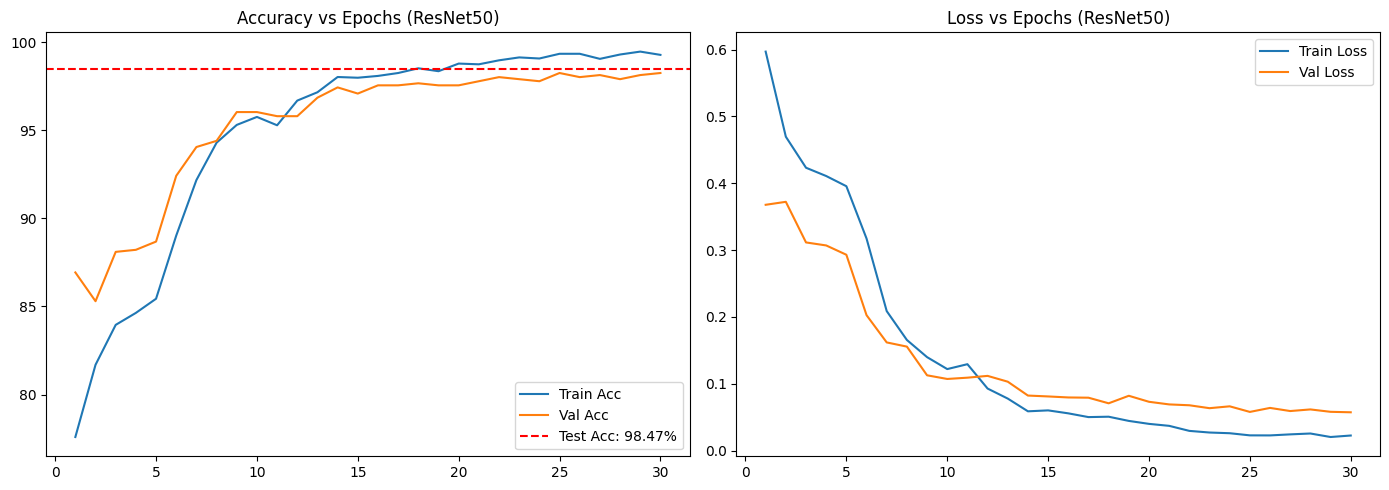

✓ Results saved to resnet50_transfer_learning_results.json
✓ Plot saved as resnet50_transfer_learning_results.png


In [14]:
end_time = time.time()
print(f"\nBest Validation Accuracy: {best_val_acc:.2f}%")
print(f"Final Test Accuracy: {test_acc:.2f}%")
print(f"Total Training Time: {(end_time - start_time)/60:.2f} minutes")

if test_acc >= 97.0:
    print("\n✓ SUCCESS! resnet50 matches or surpasses your baseline!")
elif test_acc >= 96.0:
    print("\n⚠ Close! resnet50 performs competitively but slightly below your baseline.")
else:
    print("\n⚠ Still under baseline — consider longer fine-tuning or more augmentation.")

# PLOTS
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
epochs_range = range(1, len(train_accuracies) + 1)
axes[0].plot(epochs_range, train_accuracies, label='Train Acc')
axes[0].plot(epochs_range, val_accuracies, label='Val Acc')
axes[0].axhline(y=test_acc, color='r', linestyle='--', label=f'Test Acc: {test_acc:.2f}%')
axes[0].set_title("Accuracy vs Epochs (ResNet50)")
axes[0].legend()

axes[1].plot(epochs_range, train_losses, label='Train Loss')
axes[1].plot(epochs_range, val_losses, label='Val Loss')
axes[1].set_title("Loss vs Epochs (ResNet50)")
axes[1].legend()
plt.tight_layout()
plt.savefig('resnet50_transfer_learning_results.png', dpi=300)
plt.show()

# Save metrics
results = {
    'model_name': 'ResNet50 Transfer Learning',
    'best_val_acc': best_val_acc,
    'final_test_acc': test_acc,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'train_losses': train_losses,
    'val_losses': val_losses,
}
with open('resnet50_transfer_learning_results.json', 'w') as f:
    json.dump(results, f, indent=4)
print("✓ Results saved to resnet50_transfer_learning_results.json")
print("✓ Plot saved as resnet50_transfer_learning_results.png")

#### ===========================
#### CONFUSION MATRIX
#### ===========================

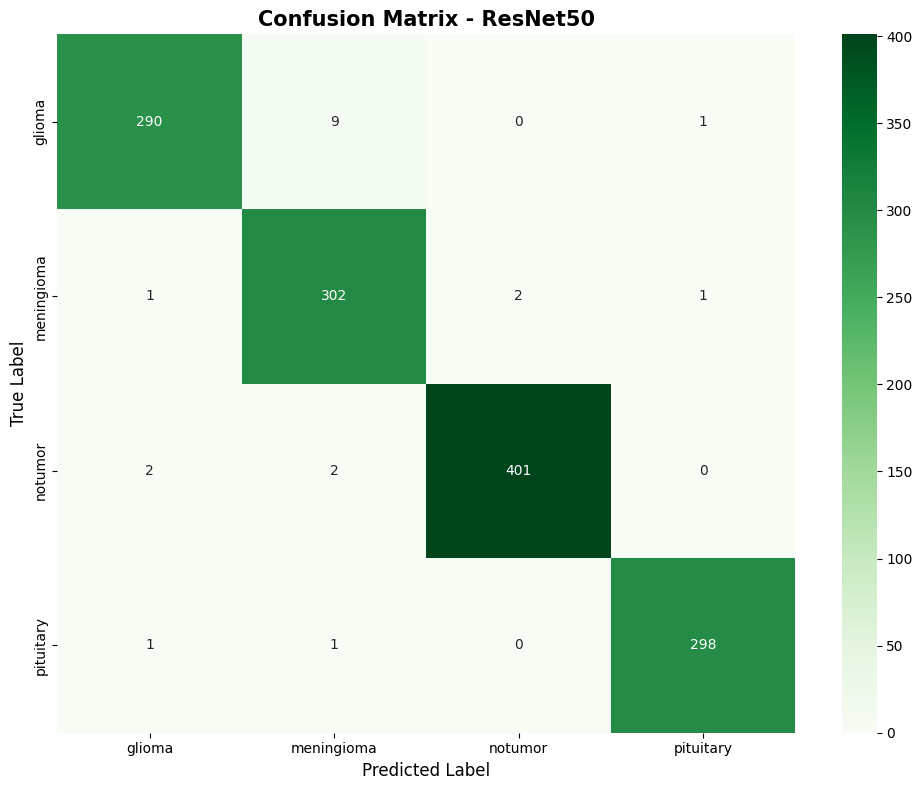

In [15]:
# Get classes from the dataset
classes = full_train_dataset.classes

y_true_list = []
y_pred_list = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        y_true_list.extend(labels.cpu().numpy())
        y_pred_list.extend(predicted.cpu().numpy())

# Generate Confusion Matrix
cm = confusion_matrix(y_true_list, y_pred_list)

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - ResNet50', fontsize=15, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

#### ===========================
#### CLASSIFICATION REPORT
#### ===========================

In [16]:
print("\nClassification Report:\n")
print(classification_report(y_true_list, y_pred_list, target_names=classes))

# Per-class Accuracy
print("\nPer-class Accuracy:")
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
for i, class_name in enumerate(classes):
    print(f"{class_name}: {cm_normalized[i, i]*100:.2f}%")


Classification Report:

              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98       300
  meningioma       0.96      0.99      0.97       306
     notumor       1.00      0.99      0.99       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311


Per-class Accuracy:
glioma: 96.67%
meningioma: 98.69%
notumor: 99.01%
pituitary: 99.33%


#### ===========================
#### VISUALIZING PREDICTIONS
#### ===========================

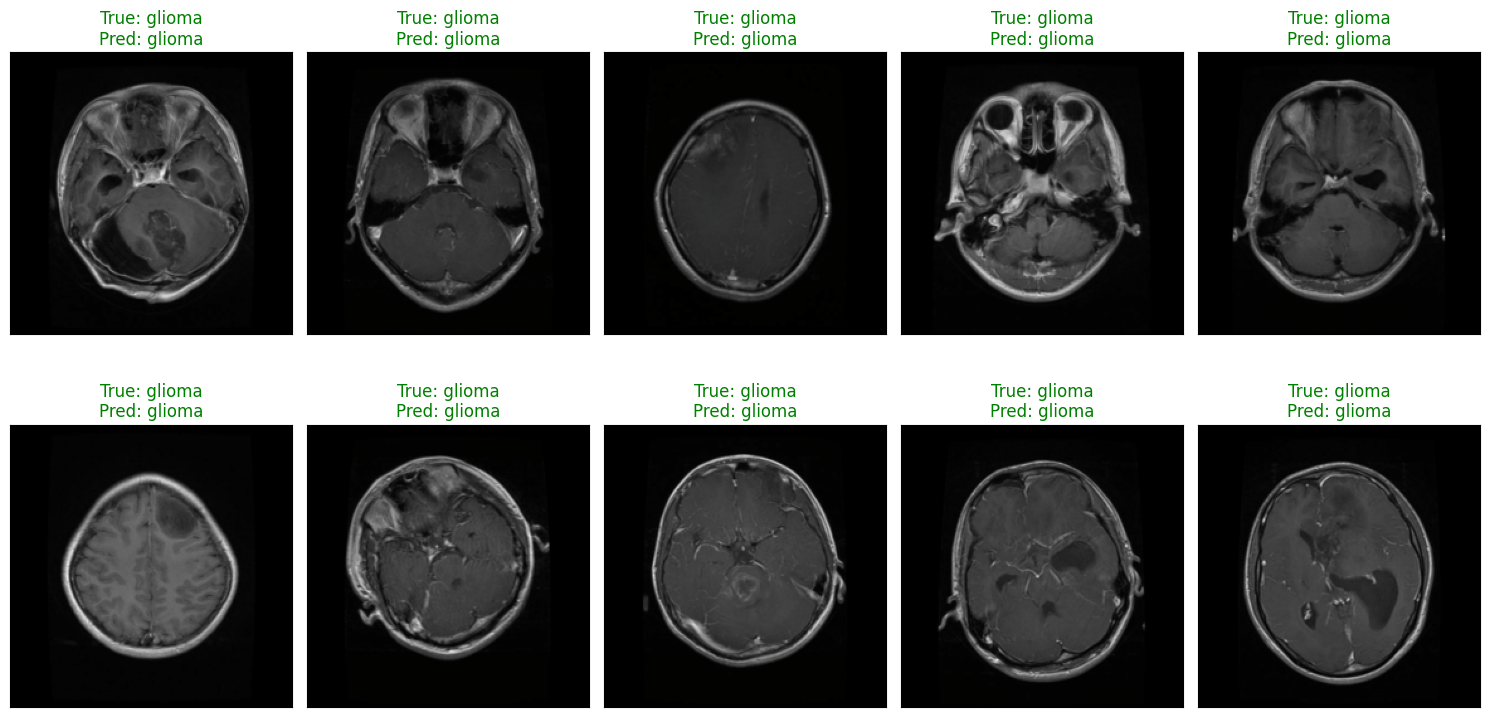

In [17]:
def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)

# Predict
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Plot
fig = plt.figure(figsize=(15, 8))
for idx in range(min(10, batch_size)): # Show up to 10 images
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    
    true_label = classes[labels[idx]]
    pred_label = classes[predicted[idx]]
    
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color)

plt.tight_layout()
plt.show()